# 1. 데이터 로드 및 전처리

In [1]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
import collections

warnings.filterwarnings(action='ignore')

PATH = '../data/'
def make_days(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    return (dt.date(year, month, day) - dt.date(2020, 10, 31)).days

def make_hours(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    return int(x[8:10])

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^\-0-9\.]+", '', str(x))
    if x =='':
        return -1
    else:
        return int(float(x))

## 데이터 불러오기

In [2]:
train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['days'] = train_err['time'].apply(make_days)
train_err['hours'] = train_err['time'].apply(make_hours)
test_err = pd.read_csv(PATH+'test_err_data.csv')
test_err['days'] = test_err['time'].apply(make_days)
test_err['hours'] = test_err['time'].apply(make_hours)

In [3]:
train_err['errcode'] = train_err['errcode'].astype(str)
test_err['errcode'] = test_err['errcode'].astype(str)

In [4]:
def is_weekend(x):
    return x % 7 <= 1

In [5]:
# 33일 넘기는 테스트 데이터 제거
test_err = test_err.loc[test_err['days'] < 33]

In [6]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 

# 날짜별 에러 발생 횟수
- 빨간색: 주말
- 파란색: 평일

In [8]:
id_error = train_err[['errtype', 'days']].values
train_error = np.zeros((33, 42))
for err, day in tqdm(id_error):
    train_error[day, err - 1] += 1
    
id_error = test_err[['errtype', 'days']].values
test_error = np.zeros((33, 42))
for err, day in tqdm(id_error):
    test_error[day, err - 1] += 1

100%|██████████████████████████████████████████████████████████████████| 16532633/16532633 [00:28<00:00, 582308.94it/s]


### train_error

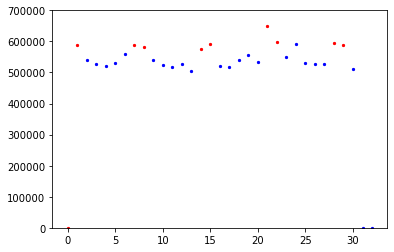

In [9]:
day_error = train_error.sum(axis=1)
for i in range(0,33):
    if is_weekend(i):
        plt.scatter(i, day_error[i], linewidth=1, color="#ff0000", s=5)
    else:
        plt.scatter(i, day_error[i], linewidth=1, color="#0000ff", s=5)
plt.ylim(0,700000)
plt.show()

## test_error

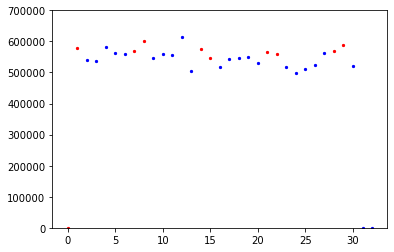

In [12]:
day_error = test_error.sum(axis=1)
for i in range(0,33):
    if is_weekend(i):
        plt.scatter(i, day_error[i], linewidth=1, color="#ff0000", s=5)
    else:
        plt.scatter(i, day_error[i], linewidth=1, color="#0000ff", s=5)
plt.ylim(0,700000)
plt.show()

# 에러가 처음 발생한 날
- 11월 1일에 대부분 에러가 발생하기 시작함
- 따라서 모든 유저는 동일한 기간동안 사용했다는 사실을 알 수 있음

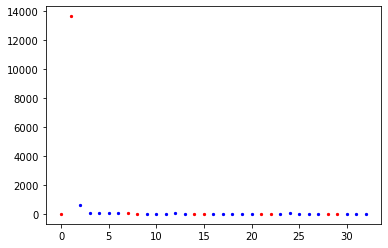

In [13]:
error_start_count = [0] * 33
for user_id, group in train_err.groupby('user_id'):
    error_start_count[group['days'].min()] += 1
for i in range(0,33):
    if is_weekend(i):
        plt.scatter(i, error_start_count[i], linewidth=1, color="#ff0000", s=5)
    else:
        plt.scatter(i, error_start_count[i], linewidth=1, color="#0000ff", s=5)

# 에러 공백기에 따른 불만 확률

In [14]:
def term(temp):
    temp = list(temp)
    temp.append(1)
    temp.append(30)
    temp.append(31)
    temp.append(32)
    temp = list(set(temp))
    temp.sort()
    best = 0
    for i in range(0, len(temp) - 1):
        diff = temp[i+1] - temp[i]
        if (best < diff):
            best = diff
    return best

In [15]:
problem_count = np.zeros(33)
no_problem_count = np.zeros(33)
for user_id, group in train_err.groupby('user_id'):
    days = group['days'].unique()
    t = term(days)
    if problem[user_id - 10000] == 1:
        problem_count[t] += 1
    else:
        no_problem_count[t] += 1

### term 분포

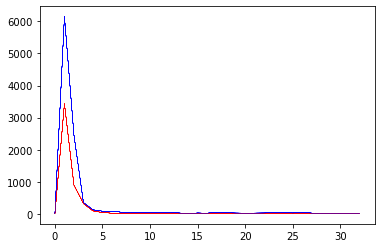

In [16]:
for i in range(0,33):
    plt.plot(range(0,33), problem_count, linewidth=0.1, color="#ff0000")
    plt.plot(range(0,33), no_problem_count, linewidth=0.1, color="#0000ff")

### 불만 접수 유저 비율

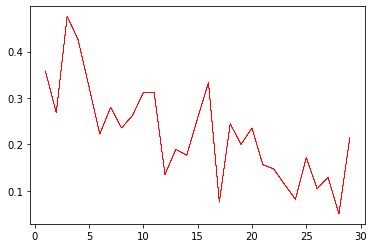

In [17]:
for i in range(0,33):
    plt.plot(range(0,33), problem_count / (problem_count + no_problem_count), linewidth=0.1, color="#ff0000")
plt.show()

# 에러에 따른 불만 유저 비율

In [31]:
def view_problem_probability(table, by, min_users=100):
    result = []
    for i, group in train_err.groupby(by):
        for cutoff in [1, 2, 3, 5, 10, 15, 30, 50, 80, 100, 150, 200, 250, 300]:
            _p = 0
            _np = 0
            for user_id, group2 in group.groupby('user_id'):
                if len(group2) >= cutoff:
                    if problem[user_id - 10000] == 1:
                        _p += 1
                    else:
                        _np += 1
            if (_p + _np > 0):
                row = []
                if len(by) == 1:
                    row += [i]
                else:
                    row += i
                row += [cutoff, _p, _np, _p+_np, _p/(_p+_np)]
                row += [sorted(group['errtype'].unique())]
                row += [sorted([i[6:] for i in group['model_nm'].unique()])]
                
                result.append(row)
            

    result = pd.DataFrame(result, columns= by + ['cutoff', 'p','np', 'users', 'p/p+np', 'types', 'model_nm'])
        
    # pd.set_option('display.max_rows', result.shape[0]+1)
    result['score'] = abs(((result['p']) / (result['p'] + result['np'])) - 0.5) * 2
    result = result.sort_values('score', ascending=False)
    return result.loc[result['users'] > min_users]

### 해석 방법
- [errtype]이 [cutoff]번 이상 발생한 유저이면 [p/p+np] 확률로 불만을 제기했다.
- [type] 컬럼은 해당 groupby가 가진 errtype.unique()
- [score] 공식: abs(problem 비율 - 0.5) * 2

In [32]:
view_problem_probability(train_err, ['errtype'])

,errtype,cutoff,p,np,users,p/p+np,types,model_nm,score
221,18,3,156,12,168,0.928571,[18],"[0, 1, 2, 3, 5, 7, 8]",0.857143
233,20,2,265,30,295,0.898305,[20],"[0, 1, 2, 5, 7, 8]",0.796610
220,18,2,389,46,435,0.894253,[18],"[0, 1, 2, 3, 5, 7, 8]",0.788506
227,19,2,100,14,114,0.877193,[19],"[0, 1, 2, 3, 5, 7, 8]",0.754386
239,21,2,89,14,103,0.864078,[21],"[0, 1, 2, 5, 7, 8]",0.728155
232,20,1,1333,213,1546,0.862225,[20],"[0, 1, 2, 5, 7, 8]",0.724450
219,18,1,1521,247,1768,0.860294,[18],"[0, 1, 2, 3, 5, 7, 8]",0.720588
287,25,2,158,26,184,0.858696,[25],"[0, 1, 2, 7, 8]",0.717391
286,25,1,360,60,420,0.857143,[25],"[0, 1, 2, 7, 8]",0.714286
288,25,3,96,16,112,0.857143,[25],"[0, 1, 2, 7, 8]",0.714286


In [33]:
view_problem_probability(train_err, ['errcode'])

,errcode,cutoff,p,np,users,p/p+np,types,model_nm,score
3601,terminate by peer user,3,131,25,156,0.839744,"[23, 25]","[0, 1, 2, 5, 7, 8]",0.679487
3577,scanning timeout,1,94,22,116,0.810345,[25],"[0, 1, 2]",0.620690
523,3,50,87,21,108,0.805556,"[30, 33, 34, 42]","[0, 1, 2, 5, 7, 8]",0.611111
409,2,80,84,21,105,0.800000,"[3, 25, 30, 33, 34, 42]","[0, 1, 2, 3, 4, 5, 7, 8]",0.600000
3600,terminate by peer user,2,275,69,344,0.799419,"[23, 25]","[0, 1, 2, 5, 7, 8]",0.598837
408,2,50,112,34,146,0.767123,"[3, 25, 30, 33, 34, 42]","[0, 1, 2, 3, 4, 5, 7, 8]",0.534247
3391,Q-64002,1,677,2155,2832,0.239054,[5],[3],0.521893
3393,Q-64002,3,511,1598,2109,0.242295,[5],[3],0.515410
3392,Q-64002,2,608,1897,2505,0.242715,[5],[3],0.514571
3394,Q-64002,5,279,857,1136,0.245599,[5],[3],0.508803


# 시간대별 에러 발생 추이
x-> 시간대별
y-> 에러 개수 (막대)

In [34]:
def timesplit1(x):
    if x >= 6 and x < 18:
        return '낮 (오전 6시~)'
    else:
        return '밤 (오후 6시~)'
    
def timesplit2(x):
    if x >= 9 and x < 15:
        return '점심'
    elif x >= 15 and x < 21:
        return '저녁'
    elif x >= 21 and x < 3:
        return '새벽'
    else:
        return '아침'

train_err['timesplit1'] = train_err['hours'].apply(timesplit1)
test_err['timesplit1'] = test_err['hours'].apply(timesplit1)

train_err['timesplit2'] = train_err['hours'].apply(timesplit2)
test_err['timesplit2'] = test_err['hours'].apply(timesplit2)

## 낮과 밤으로 구분

In [35]:
view_problem_probability(train_err, ['errtype', 'timesplit1'])

,errtype,timesplit1,cutoff,p,np,users,p/p+np,types,model_nm,score
452,20,낮 (오전 6시~),2,170,13,183,0.928962,[20],"[0, 1, 2, 5, 7, 8]",0.857923
430,18,낮 (오전 6시~),2,268,25,293,0.914676,[18],"[0, 1, 2, 3, 5, 7, 8]",0.829352
436,18,밤 (오후 6시~),2,106,13,119,0.890756,[18],"[0, 1, 2, 3, 7]",0.781513
451,20,낮 (오전 6시~),1,1122,157,1279,0.877248,[20],"[0, 1, 2, 5, 7, 8]",0.754496
461,21,낮 (오전 6시~),1,205,29,234,0.876068,[21],"[0, 1, 2, 7, 8]",0.752137
...,...,...,...,...,...,...,...,...,...,...
708,33,낮 (오전 6시~),2,2061,2076,4137,0.498187,[33],"[0, 1, 2, 5, 7, 8]",0.003626
710,33,낮 (오전 6시~),5,752,757,1509,0.498343,[33],"[0, 1, 2, 5, 7, 8]",0.003313
529,24,낮 (오전 6시~),3,366,365,731,0.500684,[24],"[0, 1, 2, 3, 5, 7, 8]",0.001368
521,23,밤 (오후 6시~),80,865,867,1732,0.499423,[23],"[0, 1, 2, 5, 7, 8]",0.001155


## 하루를 [아침, 점심, 저녁, 새벽]으로 구분

In [36]:
view_problem_probability(train_err, ['errtype', 'timesplit2'])

,errtype,timesplit2,cutoff,p,np,users,p/p+np,types,model_nm,score
644,18,점심,2,160,14,174,0.919540,[18],"[0, 1, 2, 3, 5, 7, 8]",0.839080
638,18,저녁,2,132,16,148,0.891892,[18],"[0, 1, 2, 3, 5, 7, 8]",0.783784
643,18,점심,1,892,116,1008,0.884921,[18],"[0, 1, 2, 3, 5, 7, 8]",0.769841
669,20,점심,1,760,99,859,0.884750,[20],"[0, 1, 2, 5, 7, 8]",0.769499
827,25,점심,1,170,23,193,0.880829,[25],"[0, 1, 2, 7, 8]",0.761658
...,...,...,...,...,...,...,...,...,...,...
736,23,아침,80,727,734,1461,0.497604,[23],"[0, 1, 2, 5, 7, 8]",0.004791
477,14,아침,30,174,173,347,0.501441,[14],"[0, 1, 2, 3, 4, 5, 7, 8]",0.002882
1034,32,점심,250,174,173,347,0.501441,[32],"[0, 1, 2, 5, 7, 8]",0.002882
1048,33,저녁,3,837,840,1677,0.499106,[33],"[0, 1, 2, 5, 7, 8]",0.001789
